### Importing the Libraries

In [1]:
# %%time
# Import the libraries
import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import shutil

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import models
from os import rename, listdir
import os, zipfile
import random
from random import random
from random import randrange
from random import choice
from random import uniform
from matplotlib import pyplot
import skimage.io as io

from keras.metrics import categorical_accuracy
from keras.optimizers import Adam

import tensorflow as tf 

Using TensorFlow backend.


In [2]:
# import tensorflow as tf 

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

#### Verify that the GPU is available to work with Tensorflow

In [3]:
# %%time
print('TensorFlow was built with CUDA (GPU): ' + str(tf.test.is_built_with_cuda()))
print('TensorFlow can access a GPU: ' + str(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)))
print('GPU Available: '+ str(K.tensorflow_backend._get_available_gpus()))

TensorFlow was built with CUDA (GPU): True
TensorFlow can access a GPU: True
GPU Available: ['/job:localhost/replica:0/task:0/device:GPU:0']


#### Seting the data directories

In [4]:
#Seting the directory for the images 
dir_zip = r'D:\Python\Jupyter\DeepLearning\Project\zipFiles'
dir_database = r'D:\Python\Jupyter\DeepLearning\Project\DataBase'
dir_MetaData = r'D:\Python\Jupyter\DeepLearning\Project\metaData_dataBase'
dir_project = r'D:\Python\Jupyter\DeepLearning\Project'

#### Unziping all the images

In [5]:
# %%time
extension = ".zip"

os.chdir(dir_zip) # change directory from working dir to dir with files

if len(os.listdir(os.path.abspath(dir_database)))==0 or len(os.listdir(os.path.abspath(dir_database)))==1:
    # Loop to extract all Images from a the zip file on directory
    for item in os.listdir(dir_zip): # loop through items in dir
        if item.endswith(extension): # check for ".zip" extension
            file_name = os.path.abspath(item) # get full path of files
            print("Processing %s" % file_name)
            zip_ref = zipfile.ZipFile(file_name) # create zipfile object
            os.chdir(dir_zip) # change directory from working dir to dir with files
            zip_ref.extractall(dir_database) # extract file to dir
            zip_ref.close() # close file
            #os.remove(file_name) # delete zipped file
else:
    print(len(os.listdir(os.path.abspath(dir_database))))

10019


Function to undersample dataset to test faster the modifications

In [6]:
# %%time

# from random import sample

# os.chdir(dir_database)
# if len(os.listdir(os.path.abspath(dir_database)))>500:
#     files = os.listdir(dir_database)
#     # print(files[0])
#     # print(len(files))
#     for file in sample(files,8015):
#         os.remove(file)

### Reading Metadata File

In [7]:
# %%time
#import metadata as panda dataframe
#first row is the name of the columns
#second column is the id of the images, lesions have more than one image

metadata = pd.read_csv(dir_MetaData+'/HAM10000_metadata.csv', header=0, index_col=1)

In [8]:
# Create a list of file names
#-------------------------------------------------#
filenames = [os.path.splitext(filename)[0] for filename in os.listdir(dir_database) if filename.endswith(".jpg")]
prov_filenames = []
for name in filenames:
    prov_filenames.append(name[-12:])
filenames = prov_filenames
filenames = pd.DataFrame(np.array(filenames).reshape(10015,1),columns=['filenames'])
# filenames = pd.DataFrame(np.array(filenames).reshape(2000,1),columns=['filenames'])

In [9]:
# # Organize dataset according to photos actual order
# ----------------------------------------------------
# # Merging the file names and the metadata, thus organizing the data.

organized_metadata = pd.merge(left=filenames, right=metadata, left_on='filenames',right_on='image_id')
# # print(organized_metadata)

In [10]:
# It removes all metadata but dx (lesion type)
organized_metadata['filenames_dx'] = organized_metadata['dx'] + '.' + organized_metadata['filenames']

In [11]:
# Save Metadata on Database Directoy
os.chdir(dir_database)
organized_metadata.to_csv('organized_metadata.csv', sep=',', index = False)

In [12]:
# %%time
# # Labels
# Verify whether it is useful or not
labels = np.array(organized_metadata['dx'].tolist())
filenames_dx = np.array(organized_metadata['filenames_dx'].tolist())
print(len(labels))

10015


In [13]:
# Creating Train / Val / Test folders (One time use)
lesionstype = ['nv','mel',"vasc",'akiec','bcc','bkl','df']

In [14]:
os.chdir(dir_database)

In [15]:
# %%time
def list_files(path):
    # returns a list of names (with extension, without full path) of all files 
    # in folder path
    files = []
    for name in os.listdir(path):
        if os.path.isfile(os.path.join(path, name)):
            files.append(name)
    return files 

images = list_files('.')

for img, extra in zip(images, labels) :
    filename, extension = os.path.splitext(img)
    if filename.startswith("ISIC_"):
        os.rename(img, ''.join([extra, '-', filename, extension]))
#     print(img)

In [16]:
# Listintg the file names again (After the modify them):

def get_file_list_from_dir(dir_database):
    all_files = os.listdir(os.path.abspath(dir_database))
    data_files = list(filter(lambda file: file.endswith(".jpg"), all_files))
    return data_files

filenames = get_file_list_from_dir(dir_database)

In [17]:
# Shuffle the data order:
import random
random.shuffle(filenames)

In [18]:
print(len(filenames))
print(len(labels))

10015
10015


### Spliting Train, Validate and Test Set

In [19]:
data_train, data_validate, label_train, label_validate = train_test_split(np.array(filenames), labels, 
                                                                          test_size=0.4, 
                                                                          random_state=1, 
                                                                          stratify=labels)

data_validate, data_test, label_validate, label_test = train_test_split(data_validate, label_validate, 
                                                                  test_size=0.5, 
                                                                  random_state=1, 
                                                                  stratify=label_validate)

train_filenames = [name for name in data_train.tolist()]
val_filenames = [name for name in data_validate.tolist()]
test_filenames = [name for name in data_test.tolist()]

In [20]:
print('Total images: ', len(filenames))
print('Training: ', len(train_filenames))
print('Validation: ', len(val_filenames))
print('Testing: ', len(test_filenames))

Total images:  10015
Training:  6009
Validation:  2003
Testing:  2003


In [21]:
print('Total labels: ', len(labels))
print('Training_labels: ', len(label_train))
print('Validation_labels: ', len(label_validate))
print('Testing_labels: ', len(label_test))

Total labels:  10015
Training_labels:  6009
Validation_labels:  2003
Testing_labels:  2003


In [22]:
unique_elements, counts_elements = np.unique(label_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
 ['196' '309' '659' '69' '668' '4023' '85']]


In [23]:
os.chdir(dir_database)

Spliting Images into Train / Validate / Test Directories

In [24]:
# %%time
# # Copy-pasting images: for train, validation and test

envs = dict()
envs['train'] = train_filenames
envs['test'] = test_filenames
envs['val'] = val_filenames

for env in envs:
    if not os.path.isdir(dir_database +'/'+ env): os.makedirs(dir_database +'/'+ env)
    for i in lesionstype:   
        print('Analysing '+ env + ' ' + i + ' Lesions')
        if not os.path.isdir(dir_database + '/'+env+'/' + i): os.makedirs(dir_database + '/'+env+'/' + i)
        if len(os.listdir(os.path.abspath(dir_database + '/'+env+'/' + i)))<=1:
            for name in envs[env]:
                if name.startswith(i):
                    shutil.copy(name, dir_database+"/"+env+"/"+i+"/")
        print(env+' '+i+' lesions images: '+ str(len(os.listdir(os.path.abspath(dir_database + '/'+env+'/' + i)))))
    print()
    print('---- / / ----')


Analysing train nv Lesions
train nv lesions images: 4028
Analysing train mel Lesions
train mel lesions images: 4028
Analysing train vasc Lesions
train vasc lesions images: 4028
Analysing train akiec Lesions
train akiec lesions images: 4028
Analysing train bcc Lesions
train bcc lesions images: 4028
Analysing train bkl Lesions
train bkl lesions images: 4028
Analysing train df Lesions
train df lesions images: 4028

---- / / ----
Analysing test nv Lesions
test nv lesions images: 1359
Analysing test mel Lesions
test mel lesions images: 205
Analysing test vasc Lesions
test vasc lesions images: 37
Analysing test akiec Lesions
test akiec lesions images: 63
Analysing test bcc Lesions
test bcc lesions images: 91
Analysing test bkl Lesions
test bkl lesions images: 232
Analysing test df Lesions
test df lesions images: 16

---- / / ----
Analysing val nv Lesions
val nv lesions images: 1318
Analysing val mel Lesions
val mel lesions images: 1318
Analysing val vasc Lesions
val vasc lesions images: 1318

The paths for the training and validation images

In [25]:
train_path = dir_database+"/train"
val_path = dir_database+"/val"
test_path = dir_database+"/test"

## Oversample


Balancing the classes by applying a set of random transformations in the original images of minority classes until they have the same quantity of the majority class.

#### Applied Transformations:
    Rotantion
    Width Shift
    Height Shift
    Shear Range
    Zoom
    Horizontal Flip
    Vertical Flip

In [26]:
datagen = ImageDataGenerator(
        rotation_range=randrange(0, 180, 5),
        width_shift_range=uniform(0.1,0.5),
        height_shift_range=uniform(0.1,0.4),
        shear_range=uniform(0.05,0.4),
        zoom_range=uniform(0.2,0.5),
        horizontal_flip=choice([True, False]),
        vertical_flip=choice([True, False]),
        fill_mode='nearest')

In [27]:
%%time
envs = dict()
envs['train'] = train_filenames
# envs['test'] = test_filenames
envs['val'] = val_filenames

for env in envs:
#     if len(os.listdir(os.path.abspath(dir_database)))==0: os.makedirs(dir_database +'/'+ env)
    for i in lesionstype:   
        print('Balancing '+ env + ' ' + i + ' Lesions')
        os.chdir(dir_database + '/'+env+'/'+i)
        print('Data From... '+os.getcwd()) 
        print('-------')
        if len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+i)))<len(os.listdir(os.path.abspath(dir_database + '/'+env+'/nv'))):
            images = io.ImageCollection(dir_database + '/'+env+'/'+i+'/'+i+'*', conserve_memory=True, load_func=None)
            images = io.concatenate_images(images)

#             if len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+i)))<len(os.listdir(os.path.abspath(dir_database + '/'+env+'/nv'))):
            for batch in datagen.flow(images, batch_size=1,
                                  save_to_dir=dir_database + '/'+env+'/'+i, save_prefix='aug', save_format='jpeg'):
                if len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+i)))==len(os.listdir(os.path.abspath(dir_database + '/'+env+'/nv'))):
                    break  # otherwise the generator would loop indefinitely
            print(len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+i))))                
            print('--//--')
print('Finnish!')

Balancing train nv Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\train\nv
-------
Balancing train mel Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\train\mel
-------
Balancing train vasc Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\train\vasc
-------
Balancing train akiec Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\train\akiec
-------
Balancing train bcc Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\train\bcc
-------
Balancing train bkl Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\train\bkl
-------
Balancing train df Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\train\df
-------
Balancing val nv Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\val\nv
-------
Balancing val mel Lesions
Data From... D:\Python\Jupyter\DeepLearning\Project\DataBase\val\mel
-------
Balancing val vasc Lesions
Data From... D:\Py

#### Defining:
    Batch Size(Train, Validation and Test)
    Image Resize
    Step per Iteration

In [28]:
# Declare a few useful values
num_train_samples = sum([len(files) for r, d, files in os.walk(train_path)]) #len(train_filenames) 
num_val_samples = sum([len(files) for r, d, files in os.walk(val_path)]) #len(val_filenames)
num_test_samples = sum([len(files) for r, d, files in os.walk(test_path)]) #len(test_filenames)
train_batch_size = 10
val_batch_size = 10
test_batch_size = 1

image_width = 200
image_height = 150

In [29]:
datagen = ImageDataGenerator(rescale = 1./255)

In [30]:
# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / val_batch_size)

### Set Up the generator batches

#### Train Batches

In [31]:
# Set up generators
print('Train Batches: ')
train_batches = datagen.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    batch_size=train_batch_size,
    class_mode = 'categorical',
    classes = lesionstype)

Train Batches: 
Found 28196 images belonging to 7 classes.


#### Validation Batches

In [32]:
val_batches = datagen.flow_from_directory(
    val_path,
    target_size=(image_height, image_width),
    batch_size=val_batch_size,
    class_mode = 'categorical',
    classes = lesionstype)

Found 9226 images belonging to 7 classes.


#### Test Batches

In [33]:
test_batches = datagen.flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    batch_size=test_batch_size,
    class_mode = 'categorical',
    classes = lesionstype)

Found 2003 images belonging to 7 classes.


In [34]:
for data_batch, labels_batch in train_batches:
    print('Train: data batch shape:', data_batch.shape)
    print('Train: labels batch shape:', labels_batch.shape)
    print('--//--')
    break
    
for data_batch, labels_batch in val_batches:
    print('Validation: data batch shape:', data_batch.shape)
    print('Validation: labels batch shape:', labels_batch.shape)
    print('--//--')
    break
    
for data_batch, labels_batch in test_batches:
    print('Test: data batch shape:', data_batch.shape)
    print('Test: labels batch shape:', labels_batch.shape)
    print('--//--')
    break

Train: data batch shape: (10, 150, 200, 3)
Train: labels batch shape: (10, 7)
--//--
Validation: data batch shape: (10, 150, 200, 3)
Validation: labels batch shape: (10, 7)
--//--
Test: data batch shape: (1, 150, 200, 3)
Test: labels batch shape: (1, 7)
--//--


### Custom Metrics

In [35]:
# Train the model
# Define Top2 and Top3 Accuracy

# def categorical_accuracy(y_true, y_pred):
#     return K.cast(K.equal(K.argmax(y_true, axis=-1),
#                           K.argmax(y_pred, axis=-1)),
#                   K.floatx())

def nova_recall(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    return K.cast(np.mean(recall), K.floatx())

# def nova_precision(y_true, y_pred):
#     cm = confusion_matrix(y_true, K.argmax(y_pred, axis=-1))
#     precision = np.diag(cm) / np.sum(cm, axis = 0)
#     return np.mean(precision)


def nova_precision(y_true, y_pred):
    cm = confusion_matrix(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1))
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    return K.cast(np.mean(precision), K.floatx())

### Class Weight

In [36]:
# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 1.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

## Checkpoint / Learning Rate / Callback 

In [37]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=label_train)

# Declare the filepath for the saved model
os.chdir(dir_project)
filepath = "model.h5"

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=1E-8)

callbacks_list = [checkpoint, reduce_lr]
# callbacks_list = [checkpoint]

# ---- / / ----

# GoogleNet

In [50]:
from keras import layers
from keras.models import Model

from functools import partial

conv1x1 = partial(layers.Conv2D, kernel_size=1, activation='relu')
conv3x3 = partial(layers.Conv2D, kernel_size=3, padding='same', activation='relu')
conv5x5 = partial(layers.Conv2D, kernel_size=5, padding='same', activation='relu')

def inception_module(in_tensor, c1, c3_1, c3, c5_1, c5, pp):
    conv1 = conv1x1(c1)(in_tensor)
    conv3_1 = conv1x1(c3_1)(in_tensor)
    conv3 = conv3x3(c3)(conv3_1)
    conv5_1 = conv1x1(c5_1)(in_tensor)
    conv5 = conv5x5(c5)(conv5_1)
    pool_conv = conv1x1(pp)(in_tensor)
    pool = layers.MaxPool2D(3, strides=1, padding='same')(pool_conv)
    merged = layers.Concatenate(axis=-1)([conv1, conv3, conv5, pool])
    return merged

def aux_clf(in_tensor):
    avg_pool = layers.AvgPool2D(5, 3)(in_tensor)
    conv = conv1x1(128)(avg_pool)
    flattened = layers.Flatten()(conv)
    dense = layers.Dense(1024, activation='relu')(flattened)
    dropout = layers.Dropout(0.7)(dense)
    out = layers.Dense(7, activation='softmax')(dropout)
    return out

# def inception_net(in_shape=(75,100,3), n_classes=7, opt='sgd'):
#     in_layer = layers.Input(in_shape)

def inception_net(in_shape=(150,200,3), n_classes=7, opt='sgd'):
    in_layer = layers.Input(in_shape)    
    
    conv1 = layers.Conv2D(64, 7, strides=2, activation='relu', padding='same')(in_layer)
    pad1 = layers.ZeroPadding2D()(conv1)
    pool1 = layers.MaxPool2D(3, 2)(pad1)
    conv2_1 = conv1x1(64)(pool1)
    conv2_2 = conv3x3(192)(conv2_1)
    pad2 = layers.ZeroPadding2D()(conv2_2)
    pool2 = layers.MaxPool2D(3, 2)(pad2)
    
    inception3a = inception_module(pool2, 64, 96, 128, 16, 32, 32)
    inception3b = inception_module(inception3a, 128, 128, 192, 32, 96, 64)
    pad3 = layers.ZeroPadding2D()(inception3b)
    pool3 = layers.MaxPool2D(3, 2)(pad3)
    
    inception4a = inception_module(pool3, 192, 96, 208, 16, 48, 64)
    inception4b = inception_module(inception4a, 160, 112, 224, 24, 64, 64)
    inception4c = inception_module(inception4b, 128, 128, 256, 24, 64, 64)
    inception4d = inception_module(inception4c, 112, 144, 288, 32, 48, 64)
    inception4e = inception_module(inception4d, 256, 160, 320, 32, 128, 128)
    pad4 = layers.ZeroPadding2D()(inception4e)
    pool4 = layers.MaxPool2D(3, 2)(pad4)
    
    aux_clf1 = aux_clf(inception4a)
    aux_clf2 = aux_clf(inception4d)
    
    inception5a = inception_module(pool4, 256, 160, 320, 32, 128, 128)
    inception5b = inception_module(inception5a, 384, 192, 384, 48, 128, 128)
    pad5 = layers.ZeroPadding2D()(inception5b)
    pool5 = layers.MaxPool2D(3, 2)(pad5)
    
    avg_pool = layers.GlobalAvgPool2D()(pool5)
    dropout = layers.Dropout(0.4)(avg_pool)
    preds = layers.Dense(7, activation='softmax')(dropout)
    
#     model = Model(in_layer, [preds, aux_clf1, aux_clf2])
    inception = Model(in_layer, preds)
    inception.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['categorical_accuracy'])

    return inception

if __name__ == '__main__':
    googleNet = inception_net()
    print(googleNet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 75, 100, 64)  9472        input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 77, 102, 64)  0           conv2d_119[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 38, 50, 64)   0           zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv2d_120

In [51]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

session = tf.Session(config=config)

In [52]:
history = googleNet.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=val_batches,
                              validation_steps=val_steps,
                              epochs=30,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/30
2820/2820 [==============================] - 353s 125ms/step - loss: 1.9367 - categorical_accuracy: 0.1723 - val_loss: 1.9203 - val_categorical_accuracy: 0.1777

Epoch 00001: categorical_accuracy improved from 0.14438 to 0.17233, saving model to model.h5
Epoch 2/30
2820/2820 [==============================] - 352s 125ms/step - loss: 1.7208 - categorical_accuracy: 0.2841 - val_loss: 1.6686 - val_categorical_accuracy: 0.3040

Epoch 00002: categorical_accuracy improved from 0.17233 to 0.28408, saving model to model.h5
Epoch 3/30
2820/2820 [==============================] - 351s 124ms/step - loss: 1.5599 - categorical_accuracy: 0.3770 - val_loss: 1.5325 - val_categorical_accuracy: 0.3687

Epoch 00003: categorical_accuracy improved from 0.28408 to 0.37704, saving model to model.h5
Epoch 4/30
2820/2820 [==============================] - 350s 124ms/step - loss: 1.3110 - categorical_accuracy: 0.4726 - val_loss: 1.3308 - val_categorical_accuracy: 0.4695

Epoch 00004: categorical_accu

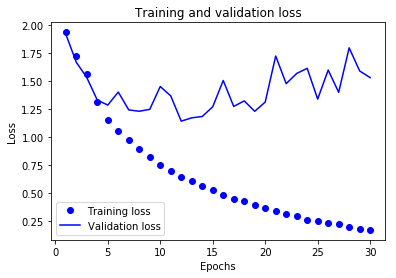

In [56]:
# Plotting the evolution of the loss, comparing training and validation
# To check if the number of epochs are not set properly

import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

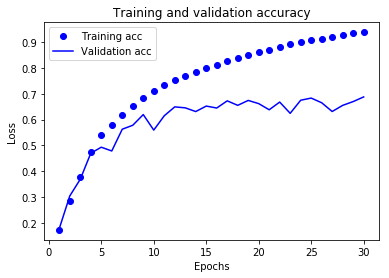

In [57]:
# Plotting the evolution of the metrics, comparing training and validation
# To check if the number of epochs are not set properly

plt.clf()      # clears the figure
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
## Evaluation of the model with metrics and confusion matrix ##

# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [60]:
### Training evaluation : Confusion matrix and metrics  ###

# Create a confusion matrix of the training images
train_labels = train_batches.classes

# Make predictions
predictions = googleNet.predict_generator(train_batches, steps=train_steps ,verbose=1)#, steps=train_steps

2820/2820 [==============================] - 230s 82ms/step


In [61]:
print(set(train_labels))
print(predictions)

{0, 1, 2, 3, 4, 5, 6}
[[3.56254902e-13 2.65275683e-11 1.00000000e+00 ... 4.15123665e-12
  2.77500462e-12 1.32611587e-13]
 [9.99989748e-01 1.31156514e-06 5.42715117e-09 ... 3.39235906e-09
  8.95356516e-06 1.21428751e-08]
 [9.99998569e-01 6.12537917e-07 3.02987124e-09 ... 1.11827205e-07
  6.53667598e-07 6.52676846e-08]
 ...
 [9.99933004e-01 6.22559892e-05 7.42078825e-08 ... 3.14554582e-09
  4.61323407e-06 3.17566751e-10]
 [3.58616979e-14 8.10208007e-08 9.74248995e-15 ... 1.94374161e-09
  4.06245175e-15 9.99999881e-01]
 [1.53169439e-11 2.30844091e-08 1.00000000e+00 ... 2.76788836e-09
  3.44343798e-09 7.41069359e-11]]


In [62]:
train_batches

In [63]:
predictions.shape

(28196, 7)

In [64]:
cm = confusion_matrix(train_labels, predictions.argmax(axis=1))
cm

array([[588, 592, 596, 592, 500, 566, 594],
       [551, 548, 607, 589, 572, 557, 604],
       [582, 589, 555, 589, 545, 569, 599],
       [601, 568, 606, 600, 548, 535, 570],
       [545, 600, 602, 564, 606, 536, 575],
       [559, 587, 582, 566, 588, 583, 563],
       [594, 569, 596, 583, 559, 542, 585]], dtype=int64)

Confusion matrix, without normalization
[[588 592 596 592 500 566 594]
 [551 548 607 589 572 557 604]
 [582 589 555 589 545 569 599]
 [601 568 606 600 548 535 570]
 [545 600 602 564 606 536 575]
 [559 587 582 566 588 583 563]
 [594 569 596 583 559 542 585]]


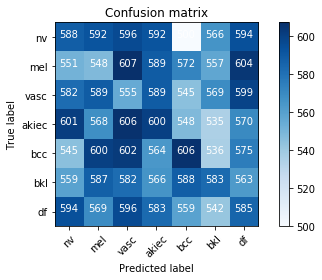

In [65]:
#cm = confusion_matrix(train_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, lesionstype)

923/923 [==============================] - 229s 248ms/step
Confusion matrix, without normalization
[[199 234 175 187 218 179 126]
 [177 232 183 191 197 193 145]
 [194 233 173 165 211 223 119]
 [179 244 181 135 202 209 168]
 [217 226 161 161 217 196 140]
 [182 214 174 153 194 257 144]
 [194 225 179 180 202 199 139]]


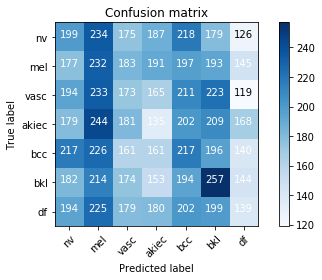

In [70]:
### Validation evaluation : Confusion matrix and metrics ###

# Create a confusion matrix of the training images
val_labels = val_batches.classes

# Make predictions
predictions = googleNet.predict_generator(val_batches, steps=val_steps, verbose=1)
cm = confusion_matrix(val_labels, predictions.argmax(axis=1))
cm_plot_labels = lesionstype
plot_confusion_matrix(cm, cm_plot_labels)

2003/2003 [==============================] - 88s 44ms/step
Confusion matrix, without normalization
[[922 157  38  37  46 145  14]
 [120  38   5   6   9  25   2]
 [ 24   6   0   0   4   3   0]
 [ 35   7   3   5   3  10   0]
 [ 58  15   1   0   4  11   2]
 [147  27   4   5  15  31   3]
 [ 11   2   1   0   0   2   0]]


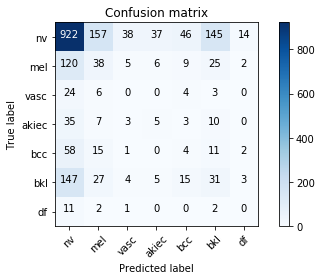

In [69]:
### Test evaluation : Confusion matrix and metrics ###

# Create a confusion matrix of the test images
test_labels = test_batches.classes

# Make predictions
predictions = googleNet.predict_generator(test_batches, steps=num_test_samples, verbose=1)
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = lesionstype
plot_confusion_matrix(cm, cm_plot_labels)